In [1]:
import xml.etree.cElementTree as et
import pandas as pd
from datetime import datetime

#pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 800)
pd.set_option('max_rows', 100)

def GetTimeinSeconds(timein):
    #2019-01-03T10:43:03.143106400Z - cut last 11 characters to round the value to seconds (int) 
    p = '%Y-%m-%dT%H:%M:%S' 
    epoch = datetime(1970, 1, 1)
    return int((datetime.strptime(timein[:-11], p) - epoch).total_seconds())

# Read an XML file created by Windows Event Viewer with the filtered Security events 4688 and 5156
parsed_xml = et.ElementTree(file="Filtered_5156_4688.xml")
#print(parsed_xml.getroot())

# Init the dataframe
dfcols = [
    'EventTime',
    'EventID',
    'Application',
    'DestAddress',
    'DestPort',
    'NewProcessName',
    'ParentProcessName'
]

df_xml = pd.DataFrame(columns=dfcols)

# Fill the dataframe
for event in parsed_xml.getroot().iter(tag='Event'):
    EventID = Application = DestAddress = DestPort = NewProcessName = ParentProcessName = EventTime = None
    for element in event.iter():
        #print ('DEBUG: Tag: %s Keys: %s Items: %s Text: %s' % (element.tag, element.keys(), element.items(), element.text))
        if element.tag == 'EventID':
            EventID = element.text
        elif element.tag == 'Data':
            if element.attrib['Name'] == 'Application':
                Application = element.text
            elif element.attrib['Name'] == 'DestAddress':
                DestAddress = element.text
            elif element.attrib['Name'] == 'DestPort':
                DestPort = element.text
            elif element.attrib['Name'] == 'NewProcessName':
                NewProcessName = element.text
            elif element.attrib['Name'] == 'ParentProcessName':
                ParentProcessName = element.text
        elif element.tag == 'TimeCreated':
            EventTime = GetTimeinSeconds(element.attrib['SystemTime'])
                
    df_xml = df_xml.append(
        pd.Series(
            [EventTime,
            EventID,
            Application,
            DestAddress,
            DestPort,
            NewProcessName,
            ParentProcessName],
            index=dfcols),
        ignore_index=True)

# Print the normalized dataframe 
df_xml


,EventTime,EventID,Application,DestAddress,DestPort,NewProcessName,ParentProcessName
0,1546512183,5156,\device\harddiskvolume3\windows\system32\svchost.exe,193.109.164.106,80,None,None
1,1546512182,5156,\device\harddiskvolume3\windows\system32\svchost.exe,193.109.164.106,80,None,None
2,1546512171,4688,None,None,None,C:\Windows\System32\backgroundTaskHost.exe,C:\Windows\System32\svchost.exe
3,1546512166,5156,\device\harddiskvolume3\windows\system32\svchost.exe,193.109.164.106,80,None,None
4,1546512164,5156,\device\harddiskvolume3\windows\system32\svchost.exe,193.109.164.106,80,None,None
...,...,...,...,...,...,...,...
1557,1524671192,4688,None,None,None,C:\Windows\System32\smss.exe,C:\Windows\System32\smss.exe
1558,1524671192,4688,None,None,None,C:\Windows\System32\setupcl.exe,C:\Windows\System32\smss.exe
1559,1524671192,4688,None,None,None,C:\Windows\System32\autochk.exe,C:\Windows\System32\smss.exe
1560,1524671191,4688,None,None,None,C:\Windows\System32\smss.exe,None


In [2]:
def AddValue2StrImage(simage, record, label):
    value = record[label]
    if value is not None:
        simage += str(value)
        if len(value):
            simage += '_'
    return simage

def GetEventStrImage(record):
    str_image = ""
    for label in dfcols:
        if label == 'EventTime': #do not add timestamp to the event string image
            continue
        str_image = AddValue2StrImage(str_image, record, label)
    return str_image

# Create and fill the dictionary for the distinct events {(event_str_image -> unique id), (unique id -> event_str_image )}
events2id_dict = {}
id2events_dict = {}

dict_idx = 0
for i in range(len(df_xml)):
    #print ("Record ID: %s, EventID: %s" % (i, df_xml.loc[i,'EventID'] ))
    event_str_image = GetEventStrImage(df_xml.iloc[i])
    if event_str_image not in events2id_dict:
        events2id_dict[event_str_image] = dict_idx
        id2events_dict[dict_idx] = event_str_image
        dict_idx += 1

id2events_dict
   

{0: '5156_\\device\\harddiskvolume3\\windows\\system32\\svchost.exe_193.109.164.106_80_',
 1: '4688_C:\\Windows\\System32\\backgroundTaskHost.exe_C:\\Windows\\System32\\svchost.exe_',
 2: '5156_\\device\\harddiskvolume3\\windows\\system32\\svchost.exe_192.168.0.1_53_',
 3: '5156_\\device\\harddiskvolume3\\program files (x86)\\microsoft office\\root\\office16\\excel.exe_52.109.8.20_443_',
 4: '5156_\\device\\harddiskvolume3\\windows\\system32\\backgroundtaskhost.exe_40.112.91.29_443_',
 5: '5156_\\device\\harddiskvolume3\\windows\\system32\\svchost.exe_52.114.128.43_443_',
 6: '5156_\\device\\harddiskvolume3\\windows\\system32\\svchost.exe_13.78.186.254_443_',
 7: '5156_\\device\\harddiskvolume3\\windows\\system32\\svchost.exe_52.161.15.246_443_',
 8: '5156_\\device\\harddiskvolume3\\windows\\system32\\svchost.exe_40.77.229.141_443_',
 9: '5156_\\device\\harddiskvolume3\\windows\\system32\\svchost.exe_13.78.187.58_443_',
 10: '5156_\\device\\harddiskvolume3\\windows\\system32\\svchost.e

Counter({130: 285, 134: 179, 2: 135, 44: 61, 1: 34, 47: 32, 244: 32, 246: 32, 14: 28, 131: 21, 10: 20, 17: 17, 241: 16, 242: 16, 243: 16, 245: 16, 247: 16, 248: 16, 249: 16, 216: 15, 7: 13, 11: 13, 152: 13, 33: 12, 135: 11, 42: 10, 43: 10, 193: 8, 6: 7, 9: 7, 37: 7, 45: 7, 56: 7, 57: 7, 82: 7, 83: 7, 100: 7, 25: 6, 27: 6, 32: 6, 38: 6, 39: 6, 127: 6, 0: 5, 4: 5, 12: 5, 63: 5, 79: 5, 85: 5, 86: 5, 119: 5, 120: 5, 29: 4, 30: 4, 61: 4, 95: 4, 96: 4, 102: 4, 118: 4, 121: 4, 191: 4, 201: 4, 224: 4, 5: 3, 36: 3, 40: 3, 41: 3, 46: 3, 55: 3, 91: 3, 98: 3, 107: 3, 110: 3, 124: 3, 125: 3, 126: 3, 128: 3, 132: 3, 140: 3, 147: 3, 194: 3, 205: 3, 208: 3, 229: 3, 231: 3, 8: 2, 13: 2, 19: 2, 20: 2, 24: 2, 26: 2, 34: 2, 35: 2, 48: 2, 60: 2, 64: 2, 65: 2, 76: 2, 77: 2, 81: 2, 99: 2, 113: 2, 115: 2, 138: 2, 139: 2, 141: 2, 142: 2, 151: 2, 153: 2, 157: 2, 158: 2, 164: 2, 168: 2, 169: 2, 171: 2, 180: 2, 182: 2, 188: 2, 189: 2, 196: 2, 197: 2, 204: 2, 210: 2, 211: 2, 212: 2, 213: 2, 217: 2, 218: 2, 219: 2,

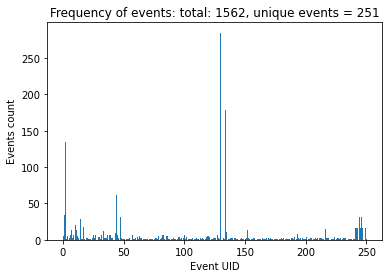

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

def GetIdByEvent(record):
    event_str_image = GetEventStrImage(record)
    return events2id_dict[event_str_image]

def GetEventById(id):
    return id2events_dict[id]

# Init the dataframe
df_single_freq_cols = [
    'UID',
    'Freq'
]

#df_single_freq = pd.DataFrame(columns=df_single_freq_cols)

UID_events_list = []
# Create a df_xml copy with UIDs
for i in range(len(df_xml)):
    UID_events_list.append(GetIdByEvent(df_xml.iloc[i]))



# Explore clusters distribution:
def exploreEvents(labels, titl):
    cntr = Counter(labels)
    plt.bar(cntr.keys(), cntr.values())
    plt.title(titl + ", unique events = " + str(len(cntr)) )
    plt.xlabel("Event UID")
    plt.ylabel("Events count")
    print(cntr)
    print("Most common events: " + str(cntr.most_common(10)))
    
    plt.show()
    
exploreEvents(UID_events_list, "Frequency of events: total: " + str(len(df_xml)))

#print (UID_events_list)
#counter=collections.Counter(UID_events_list)
#print(counter)

In [4]:
import csv

# Group events that fit a time window 

transactions_dfcols = [
    'TrID',
    'Events'
]

def AddTransaction(df, trid, record):
    df = df.append(
            pd.Series(
                [trid, [GetIdByEvent(record)]],
                index=transactions_dfcols),
        ignore_index=True)
    return df

# Init the dataframe
transactions_df = pd.DataFrame(columns=transactions_dfcols)

#Init transactions daraframe with the 1st event in df_xml
transactions_df = AddTransaction(transactions_df, 0, df_xml.iloc[0])

# the time window of a transaction in seconds between two consequent events to be linked in the transaction
TIME_WINDOW_SEC = 4

def EventInTimeWindow(record, prev_time):
    delta = abs(record['EventTime'] - prev_time)
    if (delta <= TIME_WINDOW_SEC):
        return True
    return False 

transaction_idx = 0
for i in range(1, len(df_xml)):
    prev_EventTime = df_xml.loc[i-1,'EventTime']
    cur_record = df_xml.iloc[i]
    
    # create a new transaction and add the current event
    if not EventInTimeWindow(cur_record, prev_EventTime):
        transaction_idx += 1
        transactions_df = AddTransaction(transactions_df, transaction_idx, cur_record)
    # add the event to the current transaction
    else:
        cur_transaction = transactions_df.iloc[transaction_idx]
        cur_EventDictId = GetIdByEvent(cur_record)
        if cur_EventDictId not in cur_transaction['Events']:
            cur_transaction['Events'].append(cur_EventDictId)

transactions_df.to_csv("transactions.csv", index=False, header=True, sep="\t", quoting=csv.QUOTE_NONE, quotechar="")
transactions_df.shape
transactions_df

,TrID,Events
0,0,[0]
1,1,[1]
2,2,"[0, 2]"
3,3,"[3, 2]"
4,4,"[4, 2, 1, 5, 6, 7, 8, 9, 10, 11, 12]"
...,...,...
148,148,"[241, 242, 243, 244, 245, 246, 247, 248, 249]"
149,149,"[241, 242, 243, 244, 245, 246, 247, 248, 249]"
150,150,"[241, 242, 243, 244, 245, 246, 247, 248, 249]"
151,151,"[241, 242, 243, 245, 244, 246, 247, 248, 249]"


In [5]:
import pyfpgrowth

THRESHOLD = 4
patterns = pyfpgrowth.find_frequent_patterns(transactions_df["Events"], THRESHOLD)
freq_df = pd.DataFrame(patterns.items(),columns=['items', 'freq'])
freq_df['items'] = freq_df['items'].apply(lambda x: list(x))
freq_df

,items,freq
0,[25],4
1,"[2, 25]",4
2,[29],4
3,"[1, 29]",4
4,"[2, 29]",4
...,...,...
500,"[1, 47]",4
501,"[2, 47]",8
502,[1],28
503,"[1, 2]",10


In [6]:
def IfSubsetofBiggerFP(record):
    cur_freq = record['freq']
    for i in range (len(freq_df)):
        cur_rec = freq_df.iloc[i]
        if cur_freq == cur_rec['freq']: 
            if set(record['items']) < set(cur_rec['items']):
                #print (str(record['items']) + " < " + str(cur_rec['items']) + ":" + str(cur_rec['freq']))
                return True
            
    return False

def ShrinkFPset(df):
    dropped_records = 0
    for ii in range(len(df)):
        idx = ii - dropped_records
        cur_record = df.iloc[idx]
        #print ("Current: " + str(cur_record['items']) + ":" + str(cur_record['freq']))
        if IfSubsetofBiggerFP(cur_record):
            df = df.drop(df.index[idx])
            dropped_records += 1
            #print ("Dropped: " + str(cur_record['items']))

    print ("Dropped records: " + str(dropped_records))
    return df


# Remove itemsets that are subsets of another bigger patterns with the same frequency (e.g. [5, 2]:2 < [5, 2, 1]:2 )
freq_df_reduced = ShrinkFPset(freq_df)

# Display frequent itemsets
# change columns order
freq_df_reduced = freq_df_reduced[freq_df.columns[[1,0]]]
freq_df_reduced = freq_df_reduced.sort_values(by=['freq'], ascending=False)

#save frequent itemsets to csv file 
freq_df_reduced.to_csv("freq_items.csv", index=False, header=True, sep="\t", quoting=csv.QUOTE_NONE, quotechar="")

#print frequent itemset
freq_df_reduced

Dropped records: 460


,freq,items
504,54,[2]
502,28,[1]
498,16,"[241, 242, 243, 244, 246, 247, 248, 249]"
497,16,"[241, 242, 243, 245, 246, 247, 248, 249]"
499,15,"[241, 242, 243, 244, 245, 246, 247, 248, 249]"
57,13,[130]
52,12,[10]
503,10,"[1, 2]"
56,9,"[1, 17]"
501,8,"[2, 47]"


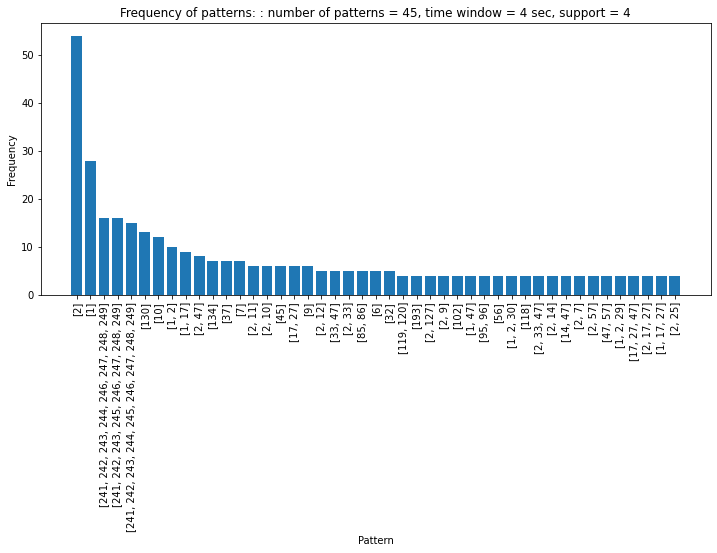

In [7]:
# Explore distribution of frequent patterns:
def exploreFreqPatterns(patterns, freqs, title):
    #fig = plt.figure(figuresize=30, 10)
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    #print ("Current size:", fig_size)
    fig_size[0] = 12
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
    plt.bar(patterns, freqs)
    plt.title(title + 
              ": number of patterns = " + str(len(patterns)) + 
              ", time window = " + str(TIME_WINDOW_SEC) + " sec" +
             ", support = " + str(THRESHOLD))
    plt.xlabel("Pattern")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.savefig("fps_distr.png", dpi=200)
    plt.show()

freq_df_reduced['items_string'] = (pd.DataFrame(freq_df_reduced['items'])
   .fillna('')
   .astype(str)
   .agg(','.join, 1)
   .str.strip(',')
)

patterns = freq_df_reduced['items_string']
freqs = freq_df_reduced['freq'].astype(int)
exploreFreqPatterns(patterns, freqs, "Frequency of patterns: ")

In [8]:
# Compare the transactions (set of events within a time window) with the frequent patterns

def FindSimilarity(transaction, pattern):
    result = 0.0
    intersec = set(transaction.loc['Events']).intersection(set(pattern.loc['items']))
    #result = len(intersec)/len(transaction['Events'])
    result = len(intersec)/(len(transaction['Events']) + len(pattern.loc['items']) - len(intersec)) #Jaccard sim coef
    return result

def FindSimilarityInFPs(transaction):
    max_sim = 0.0
    max_pattern = freq_df_reduced.iloc[0]
    for i in range(len(freq_df_reduced)):
        pat = freq_df_reduced.iloc[i]
        sim = FindSimilarity(transaction, pat)
        if(sim > max_sim):
            max_sim = sim
            max_pattern = pat
    return (max_sim, max_pattern)    

for i in range(len(transactions_df)):
    trans = transactions_df.iloc[i]
    (max_sim, max_pattern) = FindSimilarityInFPs(trans)
    transactions_df.loc[i,'Similarity'] = max_sim
    transactions_df.loc[i,'FP'] = max_pattern.loc['items_string']
    #print (str(trans.loc['Events']) + ":" + "{0:.2f}".format(max_sim) + ", pattern: " + max_pattern.loc['items_string'])

transactions_df.set_index(['Similarity'], append=True)
transactions_df

,TrID,Events,Similarity,FP
0,0,[0],0.000000,[2]
1,1,[1],1.000000,[1]
2,2,"[0, 2]",0.500000,[2]
3,3,"[3, 2]",0.500000,[2]
4,4,"[4, 2, 1, 5, 6, 7, 8, 9, 10, 11, 12]",0.181818,"[1, 2]"
...,...,...,...,...
148,148,"[241, 242, 243, 244, 245, 246, 247, 248, 249]",1.000000,"[241, 242, 243, 244, 245, 246, 247, 248, 249]"
149,149,"[241, 242, 243, 244, 245, 246, 247, 248, 249]",1.000000,"[241, 242, 243, 244, 245, 246, 247, 248, 249]"
150,150,"[241, 242, 243, 244, 245, 246, 247, 248, 249]",1.000000,"[241, 242, 243, 244, 245, 246, 247, 248, 249]"
151,151,"[241, 242, 243, 245, 244, 246, 247, 248, 249]",1.000000,"[241, 242, 243, 244, 245, 246, 247, 248, 249]"


In [9]:
# Print only anomalous transactions < Threshold
ANOMALY_THRESHOLD = 0.1

transaction_df_threshold = transactions_df[transactions_df['Similarity'] <= ANOMALY_THRESHOLD]
transaction_df_threshold.to_csv("anomalies.csv", index=False, header=True, sep="\t", quoting=csv.QUOTE_NONE, quotechar="")
transaction_df_threshold

,TrID,Events,Similarity,FP
0,0,[0],0.000000,[2]
16,16,[61],0.000000,[2]
23,23,"[73, 2, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 61, 84, 85, 86, 1, 87, 88, 89, 90, 91, 92, 93, 94]",0.080000,"[1, 2]"
34,34,"[98, 99, 100]",0.000000,[2]
35,35,"[98, 99, 100]",0.000000,[2]
60,60,[34],0.000000,[2]
72,72,[91],0.000000,[2]
85,85,[35],0.000000,[2]
104,104,[137],0.000000,[2]
108,108,"[14, 135, 131, 132, 141, 128, 142, 143, 144, 2, 145, 17, 146, 147, 125, 148, 47, 149, 150, 151, 152, 153, 154, 155, 126, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 102, 57, 168, 169, 170, 171, 100, 172, 173, 174, 175, 176, 177, 33, 140, 178, 179, 27]",0.054545,"[2, 33, 47]"


In [10]:
id2events_dict [ 79 ]

'5156_\\device\\harddiskvolume3\\program files (x86)\\microsoft office\\root\\office16\\excel.exe_52.109.120.73_443_'